# Kirti Rajesh Chaurasia - 0001046551

# Motion Deblurring

The project involves deblurring images. The blurred version is obtained through a superposition of slightly translated versions of the same image, following a random trajectory.

A convolutional neural network, ever since its conception, has almost exclusively been associated with computer vision applications. That’s because their architecture is specifically suited for performing complex visual analyses. Hence, I tried to create a CNN that can reconstruct a blurred image from the blurred image. The idea is to make it as simple as possible while also providing acceptable visual results.

## Dataset creation

In [29]:
!sudo pip3 install keras

In [47]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D, Dense, Flatten, Layer, ReLU
from keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint


We work with images obtained from MNIST.

In [31]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

In [32]:
x_train.shape

(60000, 28, 28)

In [33]:
x_test.shape

(10000, 28, 28)

Below we have the generator needed for the project. (Do not modify the number of moves, the range of translations. You are free to change the batchsize.)

In [34]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


We are creating a functino to create the blurred images of entire data including test and train sets.

In [35]:
# Function to process the entire dataset
def get_dataset(x_train, batch_size):
    gen = generator(x_train, batch_size)
    num_batches = len(x_train) // batch_size

    # Collecting processed batches
    all_blurred, all_truth = [], []
    for _ in range(num_batches):
        blurred, y_truth = next(gen)
        all_blurred.append(blurred)
        all_truth.append(y_truth)

    # Convert lists to numpy arrays
    all_blurred = np.concatenate(all_blurred, axis=0)
    all_truth = np.concatenate(all_truth, axis=0)

    return all_blurred, all_truth

In [36]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [37]:
def show(x, y, z):
    title=['Original', 'Blurred', 'predicted']
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.imshow(x)
    plt.title(title[0])
    plt.subplot(1, 3, 2)
    plt.imshow(y)
    plt.title(title[1])
    plt.subplot(1, 3, 3)
    plt.imshow(z)
    plt.title(title[2])
    plt.show()


Creating blurred data set - x_train_b is the blurred data and x_train_o is the original unblurred images, and same for the test sets.

In [38]:
batch_size = 100

x_train_b, x_train_o = get_dataset(x_train, batch_size=batch_size)

In [39]:
x_test_b, x_test_o = get_dataset(x_test, batch_size=batch_size)

Checking the size/dimension of our train and test sets so we can create our input and output layer accordingly.

In [40]:
print(x_train_b.shape)
print(x_train_o.shape)
print(x_test_b.shape)
print(x_test_o.shape)

(60000, 28, 28)
(60000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


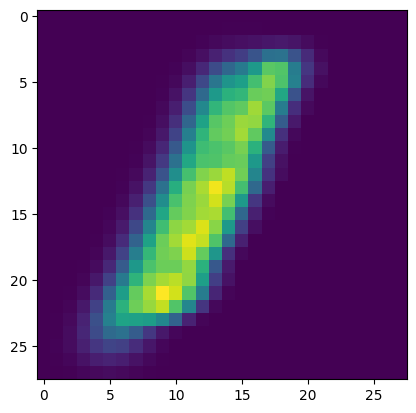

In [41]:
plt.imshow(x_train_b[700])

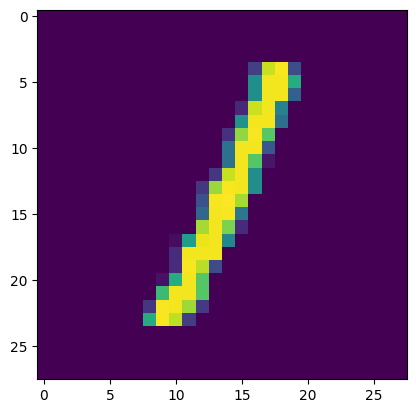

In [42]:
plt.imshow(x_train_o[700])

In [43]:
# Reshape the training data
x_train_b = x_train_b.reshape(x_train_b.shape[0], x_train_b.shape[1], x_train_b.shape[2], 1)

# Reshape the testing data
x_test_b = x_test_b.reshape(x_test_b.shape[0], x_test_b.shape[1], x_test_b.shape[2], 1)


# Reshape the training data
x_train_o = x_train_o.reshape(x_train_o.shape[0], x_train_o.shape[1], x_train_o.shape[2], 1)

# Reshape the testing data
x_test_o = x_test_o.reshape(x_test_o.shape[0], x_test_o.shape[1], x_test_o.shape[2], 1)


In [44]:
print(x_train_b.shape)
print(x_test_b.shape)
print(x_train_o.shape)
print(x_test_o.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Introduction

A Convolutional Neural Network (CNN) is used because of its ability to capture and learn hierarchical features from input data. CNNs have proven to be highly effective in computer vision tasks, including image processing tasks such as motion blur reduction or removal. They can effectively learn and generalize from the input data, making them powerful tools in tasks related to image restoration and enhancement.

We have created the following model with 2D convolutional layers with relu as the activation function. We use the kernel size of 3 and 5 overall to observe the results because our images dimension is small as of 28,28 hence it seems a good idea to keep the kernel size less than 7. We later on also tried to go as up as 7 but it did not improve things much so we kept it to 3 and 5 to have less parameters.

 Input dimensions is fixed to (28,28,1) for grayscale images. Batch size is chosen 30 because at 60 or more there was some overfitting.

 Output layer is set to have same dimensions as original images for us to be able to have accurate evaluation step.

So far we tried multiple combinitions by playing with filter sizes, kernel sizes, number and kind of layers and we have added also some initial models that started to give us good performance. The last model is the final one with best results.

## Model 1

In [ ]:
xin = Input(shape=(28,28,1))
x = Conv2D(16,kernel_size=3,padding='same',activation='relu')(xin)
x = Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(128,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=3,padding='same',activation='relu')(x)
res = Conv2D(1,kernel_size=1,activation='relu')(x)
mynet1 = Model(inputs=xin,outputs=res)

mynet1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_29 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_32 (Conv2D)          (None, 28, 28, 256)       295168    
                                                                 
 conv2d_33 (Conv2D)          (None, 28, 28, 512)       1180

In [ ]:
mynet1.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [ ]:
history1 = mynet1.fit(x_train_b, x_train_o, shuffle=True, epochs=10, batch_size=30, validation_data=(x_test_b, x_test_o))

Epoch 1/10
2000/2000 [==============================] - 60s 29ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.0113 - val_mean_squared_error: 0.0113
Epoch 2/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 3/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 4/10
2000/2000 [==============================] - 60s 30ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 5/10
2000/2000 [==============================] - 60s 30ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 6/10
2000/2000 [==============================] - 58s 29ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoc

In [ ]:
mse_scores = []
y_pred = mynet1.predict(x_test_b[:])

for i in range(10):
    # Flatten the image arrays
    y_pred_flat = y_pred.reshape(-1)
    x_test_flat = x_test_b.reshape(-1)


    # Calculate MSE for this round
    mse = mean_squared_error(x_test_flat, y_pred_flat)
    mse_scores.append(mse)

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

313/313 [==============================] - 3s 9ms/step
Mean MSE over 10 rounds: 0.05881582945585251
Standard Deviation of MSE: 0.0


## Model 2

In [ ]:
xin = Input(shape=(28,28,1))
#first set of conv2d layers
x = Conv2D(4,kernel_size=3,padding='same',activation='relu')(xin)
x = Conv2D(16,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(32,kernel_size=5,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=5,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=5,padding='same',activation='relu')(x)
#second set of conv2d layers
x = Conv2D(64,kernel_size=5,padding='same',activation='relu')(x)
x = Conv2D(128,kernel_size=5,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=5,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=5,padding='same',activation='relu')(x)
res = Conv2D(1,kernel_size=1,activation='sigmoid')(x)
mynet4 = Model(inputs=xin,outputs=res)

mynet4.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 4)         40        
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 16)        592       
                                                                 
 conv2d_37 (Conv2D)          (None, 28, 28, 32)        12832     
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 256)       205056    
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 28, 512)       3277312   
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 64)        8192

In [ ]:
mynet4.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [ ]:
history4 = mynet4.fit(x_train_b, x_train_o, shuffle=True, epochs=10, batch_size=30, validation_data=(x_test_b, x_test_o))

Epoch 1/10
2000/2000 [==============================] - 203s 97ms/step - loss: 0.1123 - mean_squared_error: 0.1123 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 2/10
2000/2000 [==============================] - 183s 92ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 3/10
2000/2000 [==============================] - 183s 92ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 4/10
2000/2000 [==============================] - 181s 91ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 5/10
2000/2000 [==============================] - 182s 91ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.1145 - val_mean_squared_error: 0.1145
Epoch 6/10
2000/2000 [==============================] - 181s 91ms/step - loss: 0.1122 - mean_squared_error: 0.1122 - val_loss: 0.1145 - val_mean_squared_error: 0.114

In [ ]:
mse_scores = []
y_pred = mynet4.predict(x_test_b[:])

for i in range(10):
    # Flatten the image arrays
    y_pred_flat = y_pred.reshape(-1)
    x_test_flat = x_test_b.reshape(-1)


    # Calculate MSE for this round
    mse = mean_squared_error(x_test_flat, y_pred_flat)
    mse_scores.append(mse)

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

313/313 [==============================] - 12s 31ms/step
Mean MSE over 10 rounds: 0.05887322500348091
Standard Deviation of MSE: 0.0


Since, using this kind of dual layer groups gave worse results, we ignore this approach and move on to modifying our model two that has given best results so far

## Model 3

In [ ]:
xin = Input(shape=(28,28,1))
x = Conv2D(4,kernel_size=3,padding='same',activation='relu')(xin)
x = Conv2D(16,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(128,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=3,padding='same',activation='relu')(x)
res = Conv2D(1,kernel_size=1,activation='relu')(x)
mynet5 = Model(inputs=xin,outputs=res)

mynet5.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Fit the model with the EarlyStopping callback
history5 = mynet5.fit(
    x_train_b, x_train_o,
    shuffle=True,
    epochs=50,
    batch_size=60,
    validation_data=(x_test_b, x_test_o),
    callbacks=[early_stopping]
)

Epoch 1/50
1000/1000 [==============================] - 64s 57ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0150 - val_mean_squared_error: 0.0150
Epoch 2/50
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 3/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 4/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0078 - val_mean_squared_error: 0.0078
Epoch 5/50
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 6/50
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoc

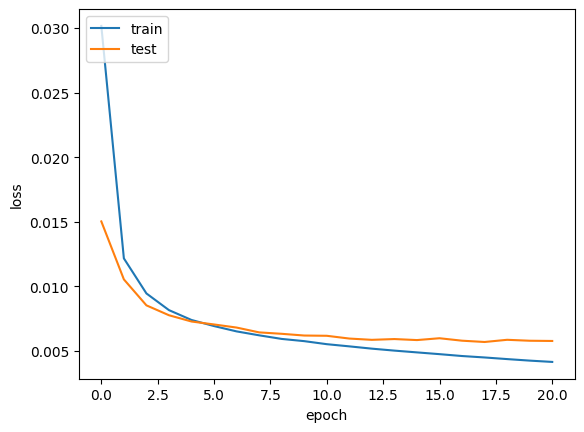

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history5,['loss','val_loss'])

In [ ]:
mse_scores = []
y_pred = mynet5.predict(x_test_b[:])

for i in range(10):
    # Flatten the image arrays
    y_pred_flat = y_pred.reshape(-1)
    x_test_flat = x_test_b.reshape(-1)


    # Calculate MSE for this round
    mse = mean_squared_error(x_test_flat, y_pred_flat)
    mse_scores.append(mse)

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

313/313 [==============================] - 3s 9ms/step
Mean MSE over 10 rounds: 0.047293148934841156
Standard Deviation of MSE: 3.725290298461914e-09


## Model 4

Lets try to add some dropout layers to see if they make any differnce in fixing the overfitting.

In [ ]:
xin = Input(shape=(28,28,1))
x = Conv2D(4,kernel_size=3,padding='same',activation='relu')(xin)
x = Conv2D(16,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
x = Dropout(0.25)(x)
x = Conv2D(64,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(128,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=3,padding='same',activation='relu')(x)
x = Dropout(0.25)(x)
res = Conv2D(1,kernel_size=1,activation='relu')(x)


mynet6 = Model(inputs=xin,outputs=res)
mynet6.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Fit the model with the EarlyStopping callback
history6 = mynet6.fit(
    x_train_b, x_train_o,
    shuffle=True,
    epochs=50,
    batch_size=60,
    validation_data=(x_test_b, x_test_o),
    callbacks=[early_stopping]
)

Epoch 1/50
1000/1000 [==============================] - 73s 71ms/step - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 2/50
1000/1000 [==============================] - 68s 68ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 3/50
1000/1000 [==============================] - 68s 68ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0086 - val_mean_squared_error: 0.0086
Epoch 4/50
1000/1000 [==============================] - 68s 68ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 5/50
1000/1000 [==============================] - 68s 68ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 0.0076 - val_mean_squared_error: 0.0076
Epoch 6/50
1000/1000 [==============================] - 66s 66ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoc

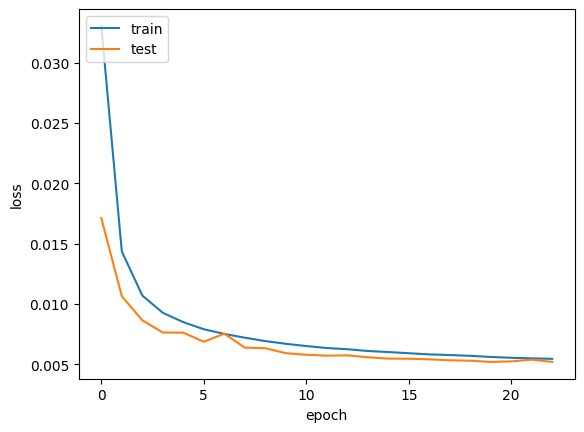

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history6,['loss','val_loss'])

our training loss is consistently decreasing, which is good. However, the validation loss decreases initially but then starts to plateau and even slightly increase. This is a classic sign of overfitting - the model is getting better at predicting the training data, but its performance on the validation data is not improving at the same rate.

In [ ]:
mse_scores = []
y_pred = mynet6.predict(x_test_b[:])

for i in range(10):
    # Flatten the image arrays
    y_pred_flat = y_pred.reshape(-1)
    x_test_flat = x_test_b.reshape(-1)


    # Calculate MSE for this round
    mse = mean_squared_error(x_test_flat, y_pred_flat)
    mse_scores.append(mse)

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

313/313 [==============================] - 4s 11ms/step
Mean MSE over 10 rounds: 0.04767486825585365
Standard Deviation of MSE: 0.0


## Model 5 - Final Model with average mse = 0.045

In [50]:
xin = Input(shape=(28,28,1))
x = Conv2D(4,kernel_size=3,padding='same',activation='relu')(xin)
x = Conv2D(16,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(64,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(128,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(256,kernel_size=3,padding='same',activation='relu')(x)
x = Conv2D(512,kernel_size=3,padding='same',activation='relu')(x)
res = Conv2D(1,kernel_size=1,activation='relu')(x)
mynet5 = Model(inputs=xin,outputs=res)

mynet5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 28, 28, 4)         40        
                                                                 
 conv2d_41 (Conv2D)          (None, 28, 28, 16)        592       
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 conv2d_44 (Conv2D)          (None, 28, 28, 128)       73856     
                                                                 
 conv2d_45 (Conv2D)          (None, 28, 28, 256)       2951

In [51]:
mynet5.compile(optimizer='adam',loss='mse', metrics=[tf.keras.metrics.MeanSquaredError()])

In [53]:
checkpoint_path = 'model_checkpoint.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max')

In [54]:
history5 = mynet5.fit(x_train_b, x_train_o, shuffle=True, epochs=10, batch_size=30, validation_data=(x_test_b, x_test_o),callbacks=[checkpoint])


Epoch 1/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0115 - mean_squared_error: 0.0115

2000/2000 [==============================] - 59s 29ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 2/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0084 - mean_squared_error: 0.0084

2000/2000 [==============================] - 59s 29ms/step - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.0079 - val_mean_squared_error: 0.0079
Epoch 3/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0073 - mean_squared_error: 0.0073

2000/2000 [==============================] - 58s 29ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 4/10
2000/2000 [==============================] - ETA: 0s - loss: 0.0067 - mean_squared_error: 0.0067

2000/2000 [==============================] - 61s 30ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 5/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0063 - mean_squared_error: 0.0063

2000/2000 [==============================] - 58s 29ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 6/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0059 - mean_squared_error: 0.0059

2000/2000 [==============================] - 57s 29ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 7/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0057 - mean_squared_error: 0.0057

2000/2000 [==============================] - 59s 29ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 8/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0055 - mean_squared_error: 0.0055

2000/2000 [==============================] - 59s 29ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 9/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0053 - mean_squared_error: 0.0053

2000/2000 [==============================] - 57s 28ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0057 - val_mean_squared_error: 0.0057
Epoch 10/10
1999/2000 [============================>.] - ETA: 0s - loss: 0.0051 - mean_squared_error: 0.0051

2000/2000 [==============================] - 57s 28ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0056 - val_mean_squared_error: 0.0056


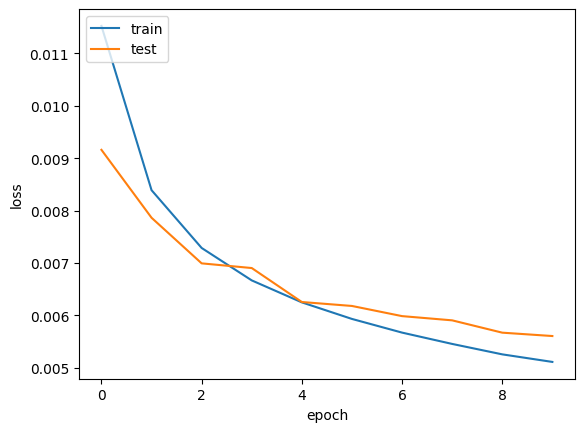

In [55]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history5,['loss','val_loss'])

### Evaluation

Using Mean Squared Error (mse) to evaluate the error between the deblurred image and the ground truth. Measuring mse on 10000 blurred versions of the validation set. Repeated the previous computation 10 times, and gave a result as mean mse over the ten rounds, along with the standard deviation.

The best Model is chosen and visualized.

In [56]:
mse_scores = []
y_pred = mynet5.predict(x_test_b[:])

for i in range(10):
    # Flatten the image arrays
    y_pred_flat = y_pred.reshape(-1)
    x_test_flat = x_test_b.reshape(-1)


    # Calculate MSE for this round
    mse = mean_squared_error(x_test_flat, y_pred_flat)
    mse_scores.append(mse)

# Calculate mean and standard deviation of MSE scores
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print(f"Mean MSE over 10 rounds: {mean_mse}")
print(f"Standard Deviation of MSE: {std_mse}")

313/313 [==============================] - 4s 11ms/step
Mean MSE over 10 rounds: 0.04827576130628586
Standard Deviation of MSE: 3.725290298461914e-09


313/313 [==============================] - 3s 9ms/step


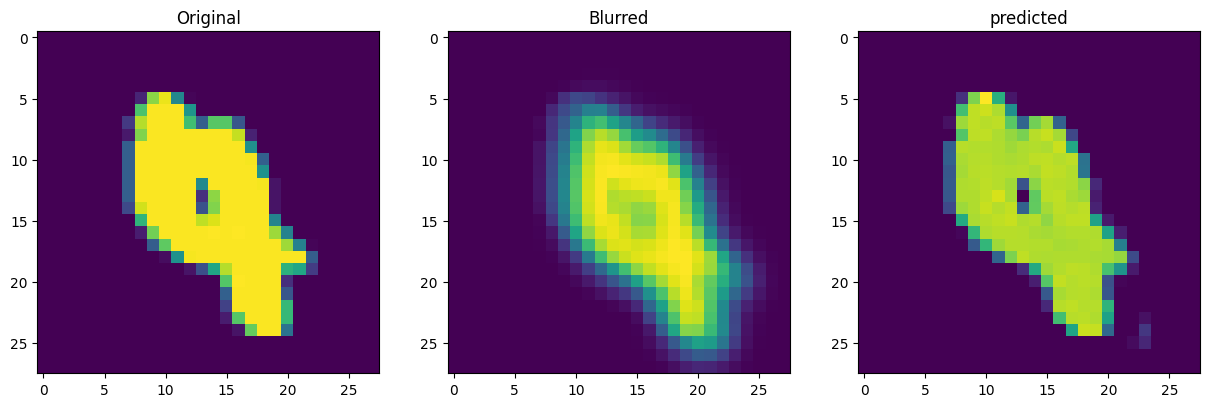

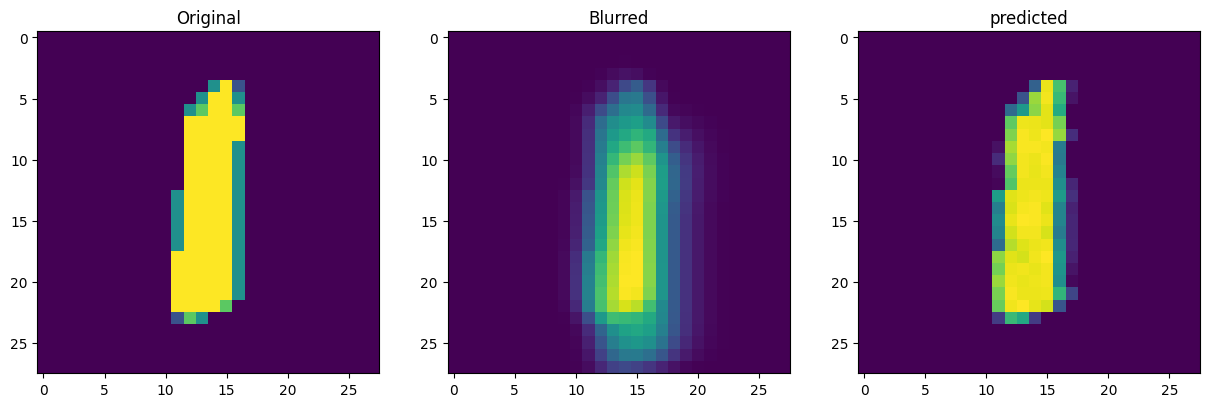

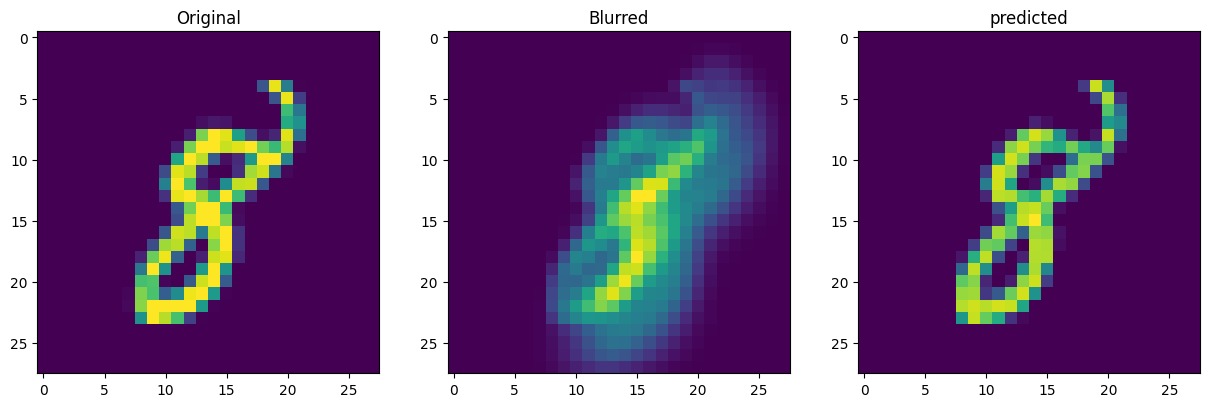

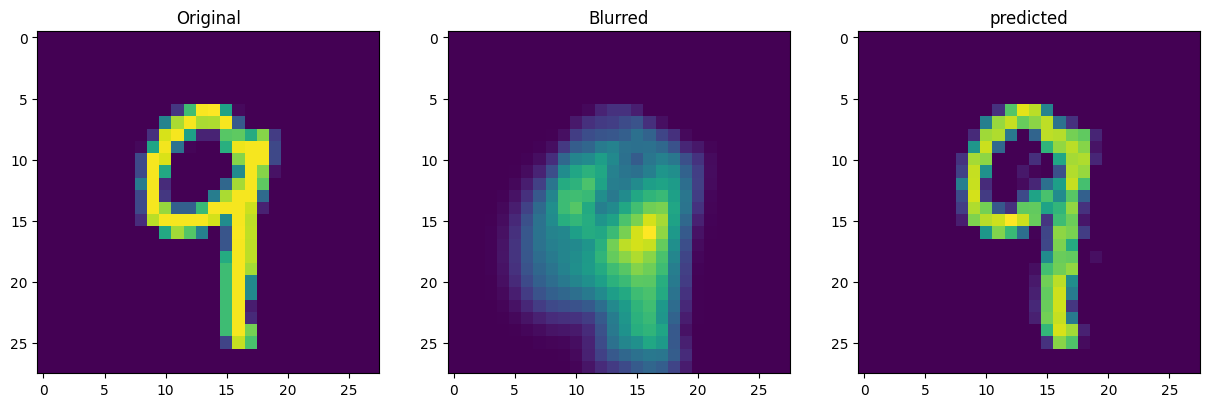

In [57]:
# Qualitative results
y_pred = mynet5.predict(x_test_b[:])
show(x_test_o[31, :, :], x_test_b[31, :, :], y_pred[31, :, :, :])
show(x_test_o[7, :, :], x_test_b[7, :, :], y_pred[7, :, :, :])
show(x_test_o[21, :, :], x_test_b[21, :, :], y_pred[21, :, :, :])
show(x_test_o[17, :, :], x_test_b[17, :, :], y_pred[17, :, :, :])